# マーク付き点過程モデル デモ

このノートブックでは、新しく実装したマーク付き点過程モデルを実データ（黒曜石）で実行します。

## モデル概要

- **点過程部分**: 遺跡の存在確率 $q(s) = \text{sigmoid}(\eta_{\text{int}})$
- **マーク部分**: 産地構成比 $\pi_k(s) = \text{softmax}(\eta_k)$
- **空間効果**: NNGP（Nearest Neighbor Gaussian Process）による空間相関

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import japanize_matplotlib

from bayesian_statistics.models.preprocessing.data_preprocessor import (
    ObsidianDataPreprocessor,
)
from bayesian_statistics.nngp.model.marked_point_process import (
    MarkedPointProcessConfig,
    MarkedPointProcessSampler,
    compute_eta,
    prepare_marked_point_process_dataset,
    softmax_with_baseline,
)

print("モジュール読み込み完了")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


モジュール読み込み完了


## 1. データの準備

`prepare_marked_point_process_dataset`を使用して実データを読み込みます。

In [2]:
data_dir = "/home/ohta/dev/bayesian_statistics/data"
preprocessor = ObsidianDataPreprocessor(data_dir, scale_variables=True)
preprocessor.load_data()

period = 2  # 中期
origins = ["神津島", "信州", "箱根", "高原山", "その他"]
grid_subsample_ratio = 0.01

time_periods = {0: "早期・早々期", 1: "前期", 2: "中期", 3: "後期", 4: "晩期"}

intensity_variable_names = ["average_elevation", "average_slope_angle"]

print(f"時期: {time_periods[period]}")
print(f"産地: {origins}")

時期: 中期
産地: ['神津島', '信州', '箱根', '高原山', 'その他']


In [3]:
# データセット準備
dataset = prepare_marked_point_process_dataset(
    preprocessor=preprocessor,
    period=period,
    origins=origins,
    grid_subsample_ratio=grid_subsample_ratio,
    drop_zero_total_sites=True,
    intensity_variable_names=intensity_variable_names,
)

print(f"遺跡数: {dataset.num_sites()}")
print(f"カテゴリ数: {dataset.num_categories()}")
print(f"グリッド数: {dataset.num_grid()}")
print(f"有効グリッド数: {dataset.valid_grids.sum()}")
print(f"領域面積: {dataset.volume:.4f}")

遺跡数: 146
カテゴリ数: 5
グリッド数: 13575
有効グリッド数: 7798
領域面積: 8.8226


In [4]:
# 産地別出土数
counts_sum = dataset.counts.sum(axis=0)
print("産地別出土数:")
for k, origin in enumerate(origins):
    pct = counts_sum[k] / counts_sum.sum() * 100
    print(f"  {origin}: {int(counts_sum[k])} ({pct:.1f}%)")

産地別出土数:
  神津島: 10277 (61.5%)
  信州: 4626 (27.7%)
  箱根: 442 (2.6%)
  高原山: 128 (0.8%)
  その他: 1244 (7.4%)


## 2. 可視化用の境界データ準備

In [5]:
# 境界（可視化用）
boundary = (
    preprocessor.df_elevation.filter(
        pl.col("average_elevation").is_null(), ~pl.col("is_sea")
    )
    .select(["x", "y"])
    .to_numpy()
)

print(f"境界点数: {len(boundary)}")

境界点数: 10416


## 3. MCMC設定

In [6]:
# MCMC設定
config = MarkedPointProcessConfig(
    n_iter=300,             # イテレーション数
    burn_in=100,            # バーンイン
    thinning=2,             # 間引き
    seed=42,                # 乱数シード
    neighbor_count=25,      # NNGP近傍数
    mark_kernel_lengthscale=0.1,   # マークカーネルのレンジ
    mark_kernel_variance=0.05,      # マークカーネルの分散
    lambda_prior_shape=2.0,        # λ*の事前分布shape
    lambda_prior_rate=0.1,         # λ*の事前分布rate
)

print(f"保存サンプル数: {config.n_saved()}")

保存サンプル数: 100


## 4. MCMCの実行

In [7]:
# サンプラー初期化と実行
sampler = MarkedPointProcessSampler(dataset, config)

print("MCMC実行中...")
results = sampler.run(show_progress=True)
print("完了!")
print(f"保存サンプル数: {len(results.lambda_star_samples)}")

100%|██████████| 13575/13575 [00:04<00:00, 3083.30it/s]


MCMC実行中...


MCMC: 100%|██████████| 300/300 [00:35<00:00,  8.53it/s]

完了!
保存サンプル数: 100


## 5. 結果の確認

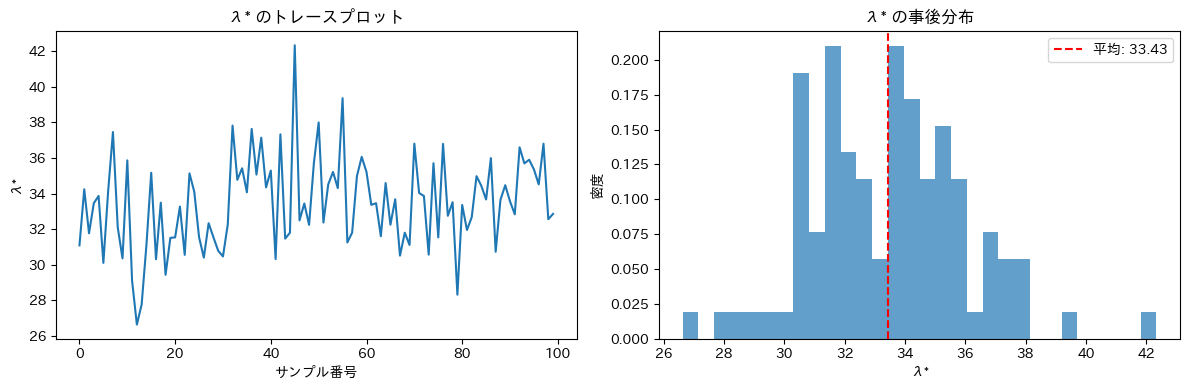

In [8]:
# λ*のトレースプロット
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
ax.plot(results.lambda_star_samples)
ax.set_xlabel('サンプル番号')
ax.set_ylabel('λ*')
ax.set_title('λ* のトレースプロット')

ax = axes[1]
ax.hist(results.lambda_star_samples, bins=30, density=True, alpha=0.7)
ax.axvline(results.lambda_star_samples.mean(), color='red', linestyle='--', 
           label=f'平均: {results.lambda_star_samples.mean():.2f}')
ax.set_xlabel('λ*')
ax.set_ylabel('密度')
ax.set_title('λ* の事後分布')
ax.legend()

plt.tight_layout()
plt.show()

In [9]:
# 事後平均で構成比を計算
beta_mean = results.beta_mark_samples.mean(axis=0)  # (K-1, p+1, n_sites)
eta_mean = compute_eta(beta_mean, dataset.design_matrix_marks)
site_probs = softmax_with_baseline(eta_mean)  # (K, n_sites)

# 実測比率
true_ratio = dataset.counts / dataset.counts.sum(axis=1, keepdims=True)
true_ratio = np.nan_to_num(true_ratio).T  # (K, n_sites)

print(f"事後平均 β の形状: {beta_mean.shape}")
print(f"推定確率 π の形状: {site_probs.shape}")

事後平均 β の形状: (4, 1, 146)
推定確率 π の形状: (5, 146)


## 6. 事後平均の可視化

In [10]:
def plot_result(origin_index: int):
    """特定産地の事後平均をプロット"""
    fig, ax = plt.subplots(1, 1, figsize=(10, 8), constrained_layout=True)

    # 観測地点の推定確率
    sc = ax.scatter(
        dataset.site_coords[:, 0],
        dataset.site_coords[:, 1],
        c=site_probs[origin_index],
        cmap="Blues",
        s=50,
        alpha=0.8,
        vmin=0,
        vmax=1,
        edgecolors="black",
        linewidths=0.5,
    )

    # 境界
    ax.scatter(boundary[:, 0], boundary[:, 1], c="grey", s=0.001)

    plt.colorbar(sc, ax=ax, label="事後平均確率")
    ax.set_title(f"{origins[origin_index]}産黒曜石の組成比（{time_periods[period]}）")
    ax.set_xlabel("経度")
    ax.set_ylabel("緯度")

    for spine in ax.spines.values():
        spine.set_linewidth(0.5)

    plt.show()

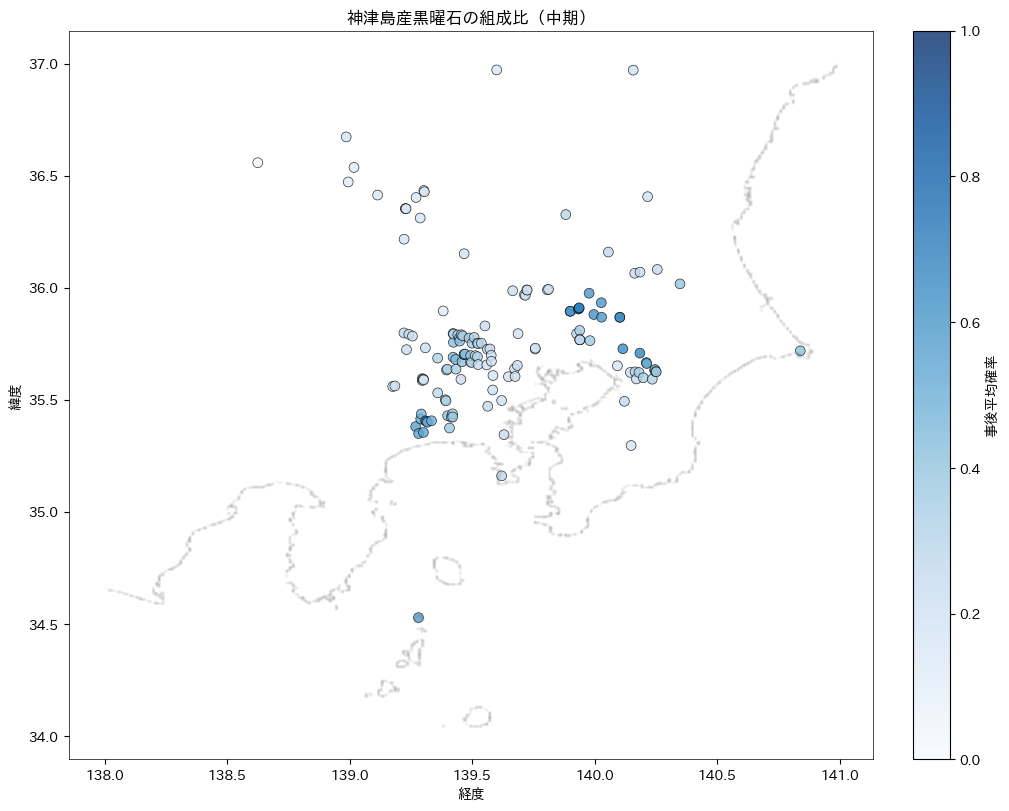

In [11]:
# 神津島
plot_result(0)

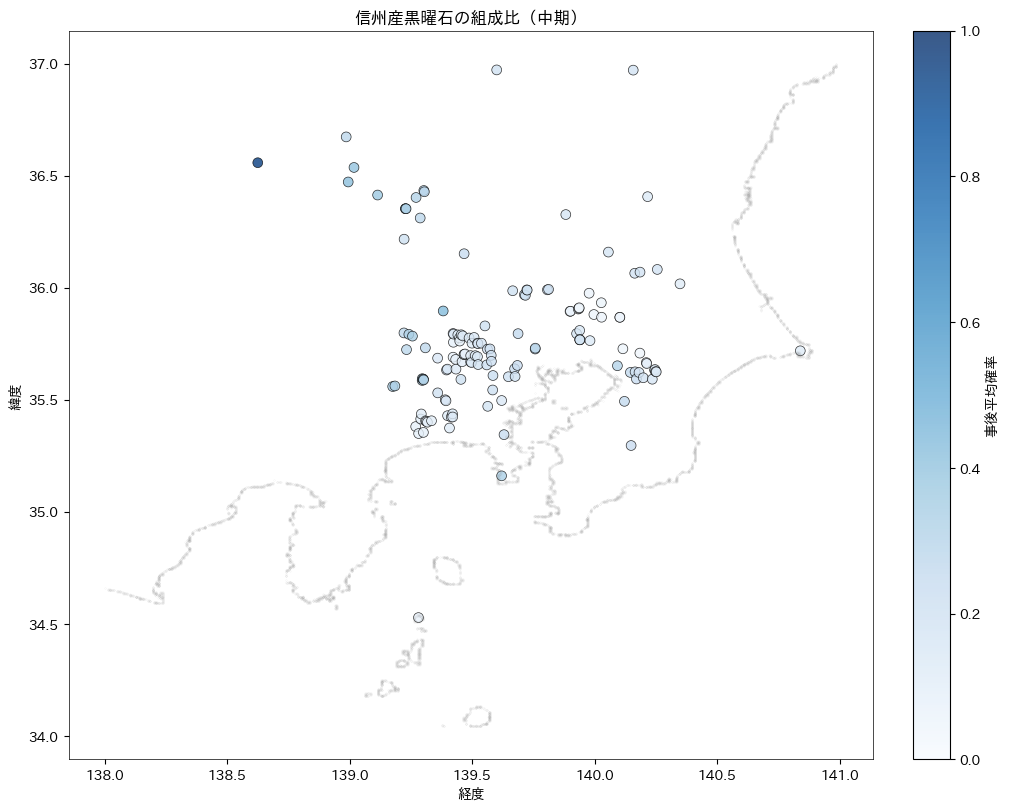

In [12]:
# 信州
plot_result(1)

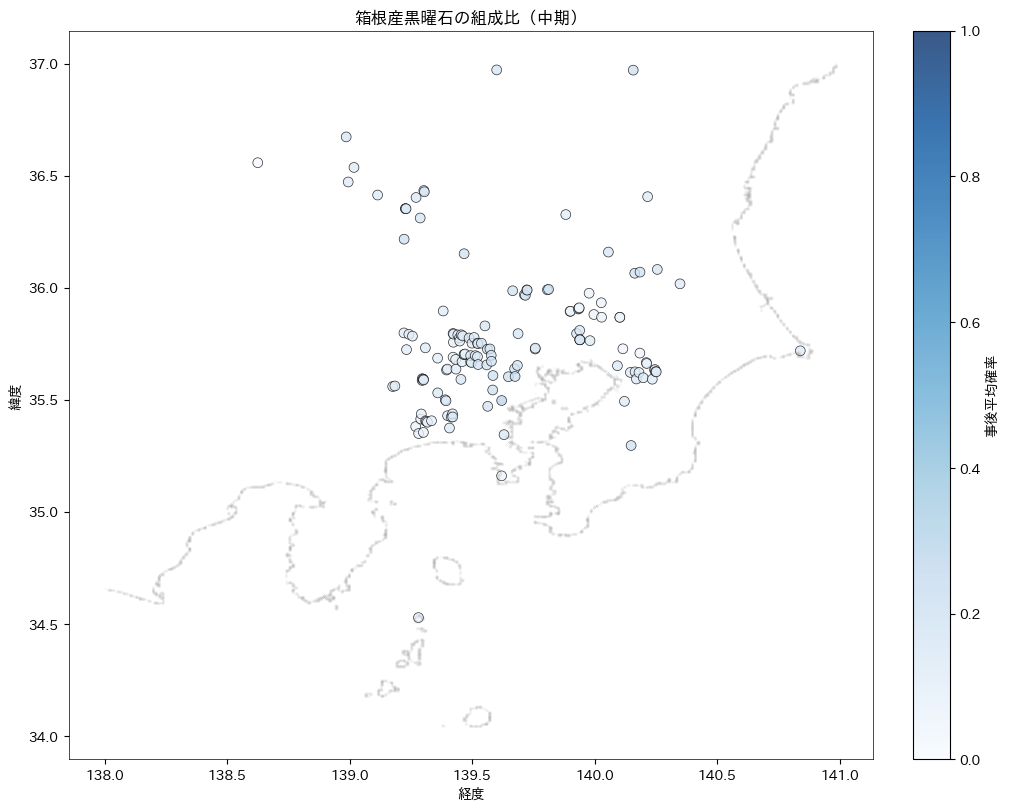

In [13]:
# 箱根
plot_result(2)

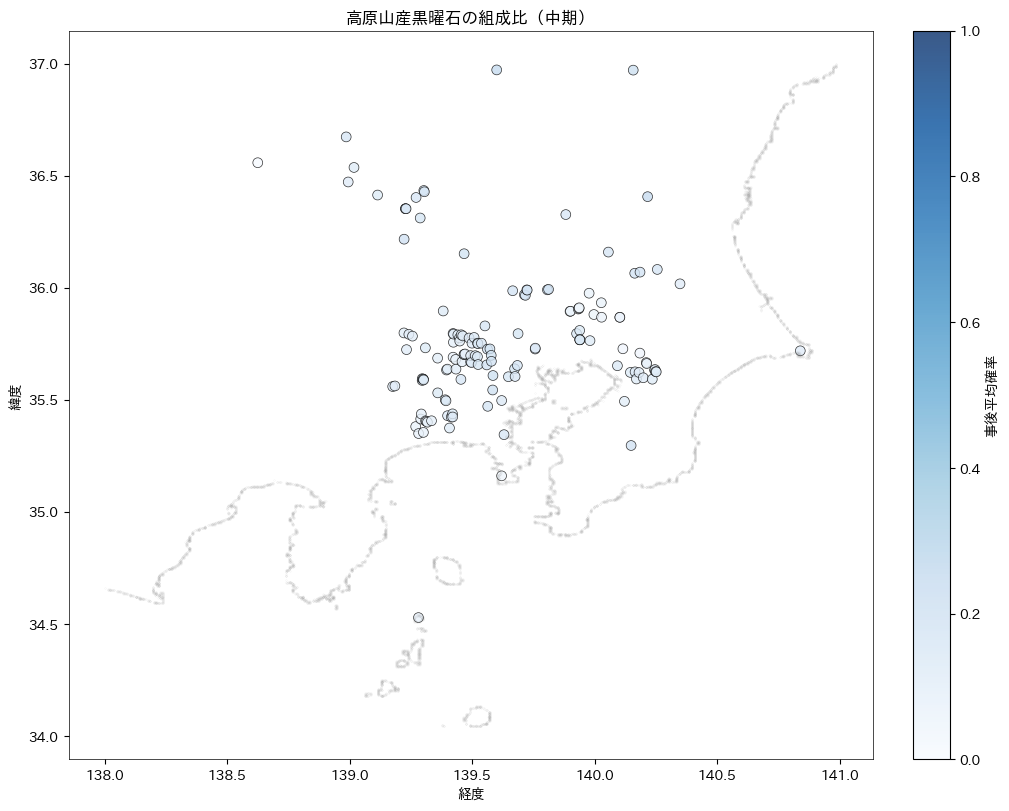

In [14]:
# 高原山
plot_result(3)

## 7. 推定値と実測値の比較

In [15]:
def plot_comparison(origin_index: int):
    """推定値と実測値を並べてプロット"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

    # 推定値
    ax = axes[0]
    sc = ax.scatter(
        dataset.site_coords[:, 0],
        dataset.site_coords[:, 1],
        c=site_probs[origin_index],
        cmap="Blues",
        s=50,
        alpha=0.8,
        vmin=0,
        vmax=1,
        edgecolors="black",
        linewidths=0.5,
    )
    ax.scatter(boundary[:, 0], boundary[:, 1], c="grey", s=0.001)
    plt.colorbar(sc, ax=ax, label="確率")
    ax.set_title(f"{origins[origin_index]}: 推定値（事後平均）")
    ax.set_xlabel("経度")
    ax.set_ylabel("緯度")
    
    # 実測値
    ax = axes[1]
    sc = ax.scatter(
        dataset.site_coords[:, 0],
        dataset.site_coords[:, 1],
        c=true_ratio[origin_index],
        cmap="Blues",
        s=50,
        alpha=0.8,
        vmin=0,
        vmax=1,
        edgecolors="black",
        linewidths=0.5,
    )
    ax.scatter(boundary[:, 0], boundary[:, 1], c="grey", s=0.001)
    plt.colorbar(sc, ax=ax, label="比率")
    ax.set_title(f"{origins[origin_index]}: 実測値")
    ax.set_xlabel("経度")
    ax.set_ylabel("緯度")

    for ax in axes:
        for spine in ax.spines.values():
            spine.set_linewidth(0.5)

    plt.show()

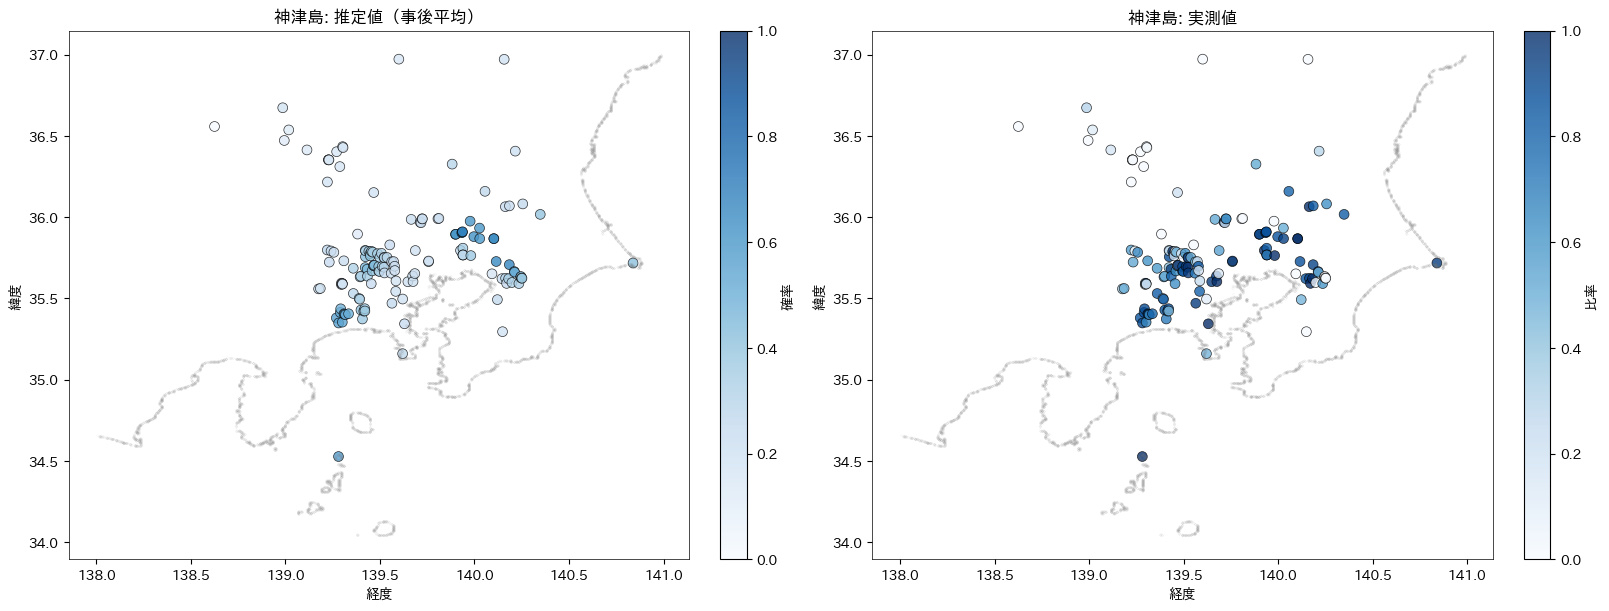

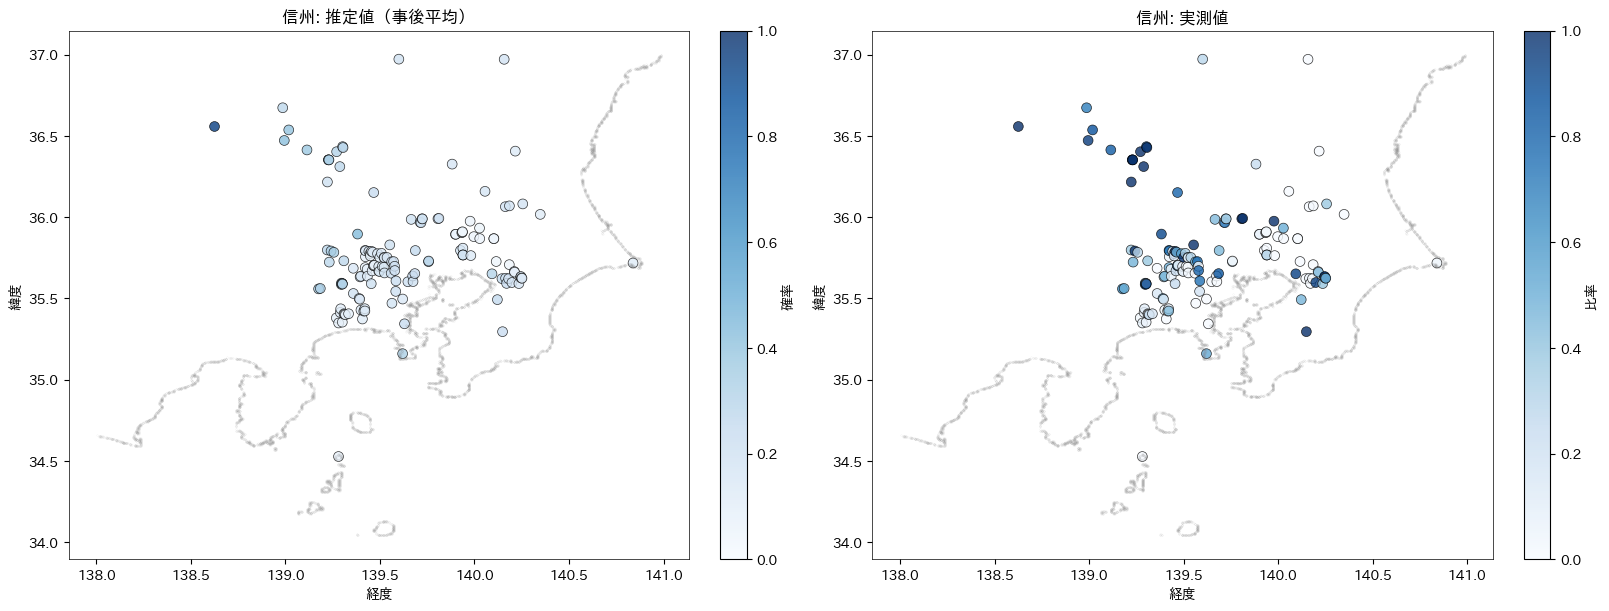

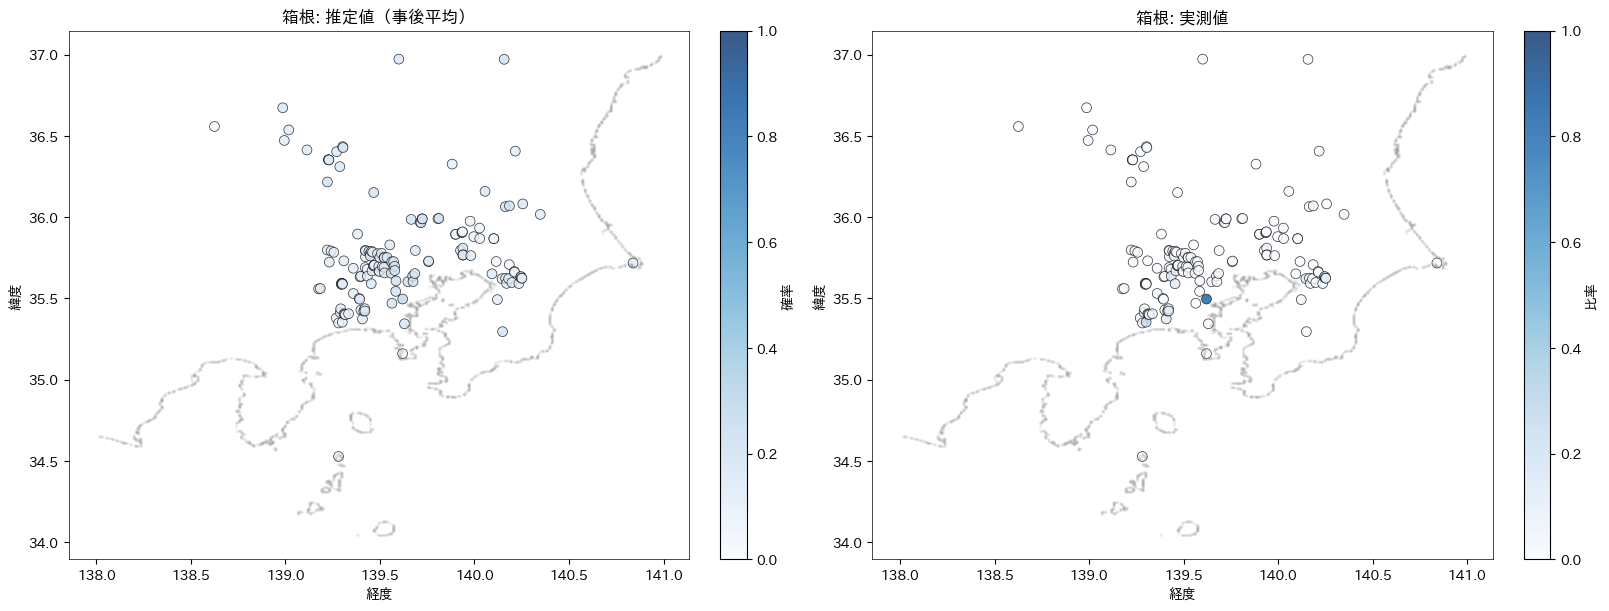

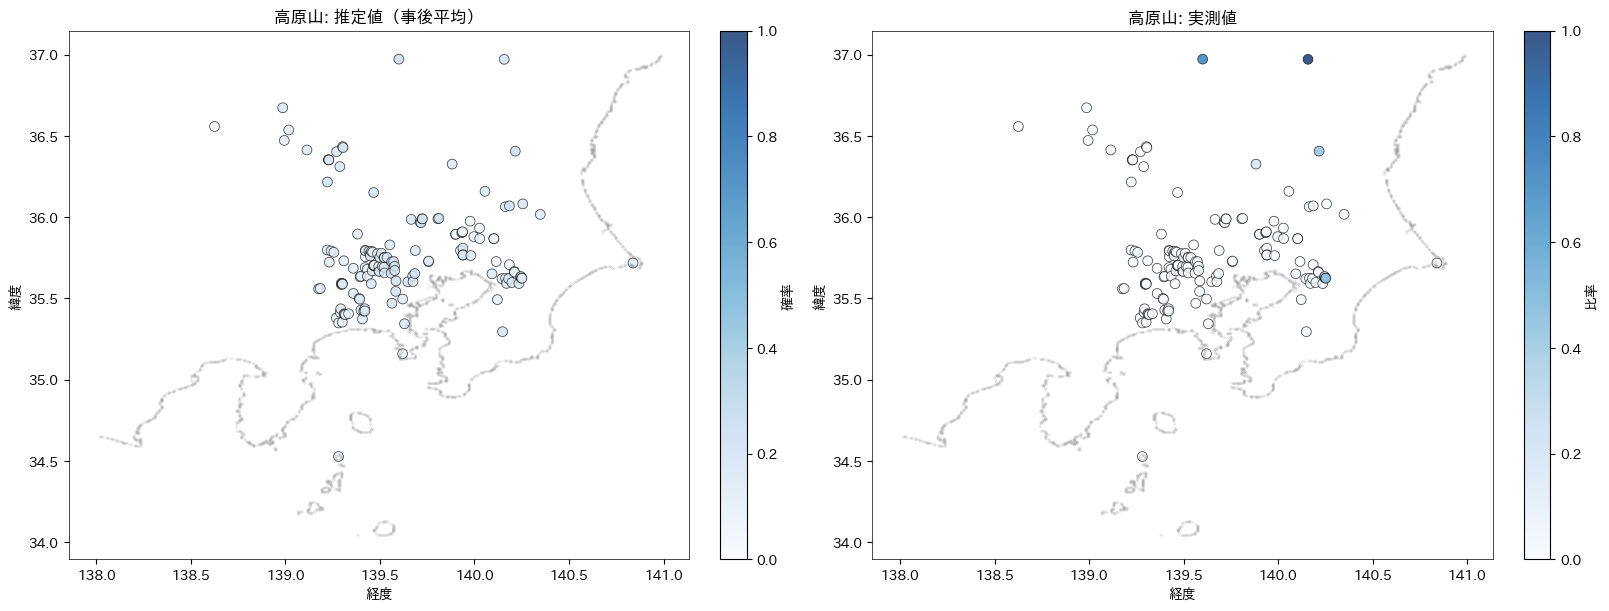

In [16]:
# 4産地について比較
for k in range(4):
    plot_comparison(k)

## 8. 全産地の一覧表示

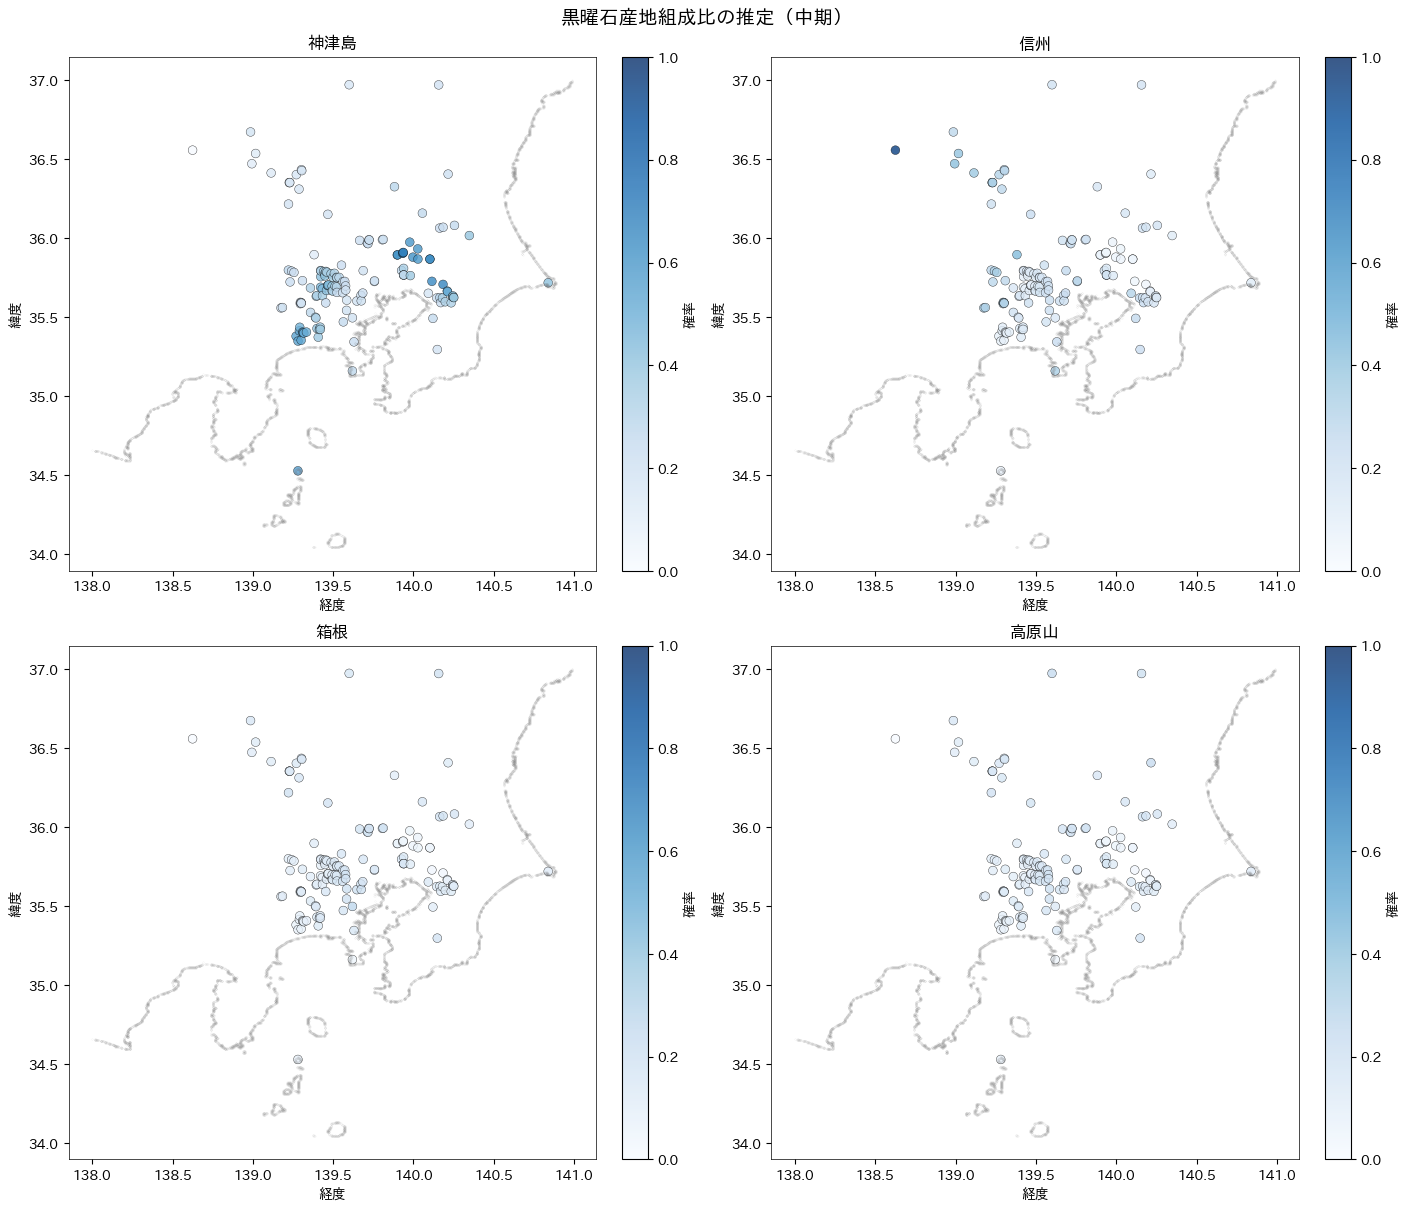

In [17]:
def plot_all_origins():
    """全産地（4つ）を2×2で比較プロット"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 12), constrained_layout=True)
    axes = axes.flatten()

    for idx in range(4):  # 4つの主要産地
        ax = axes[idx]
        
        # 推定確率
        sc = ax.scatter(
            dataset.site_coords[:, 0],
            dataset.site_coords[:, 1],
            c=site_probs[idx],
            cmap="Blues",
            s=40,
            alpha=0.8,
            vmin=0,
            vmax=1,
            edgecolors="black",
            linewidths=0.3,
        )
        
        # 境界
        ax.scatter(boundary[:, 0], boundary[:, 1], c="grey", s=0.001)

        plt.colorbar(sc, ax=ax, label="確率")
        ax.set_title(f"{origins[idx]}")
        ax.set_xlabel("経度")
        ax.set_ylabel("緯度")

        for spine in ax.spines.values():
            spine.set_linewidth(0.5)

    fig.suptitle(f"黒曜石産地組成比の推定（{time_periods[period]}）", fontsize=14)
    plt.show()

plot_all_origins()

## 9. 散布図による精度評価

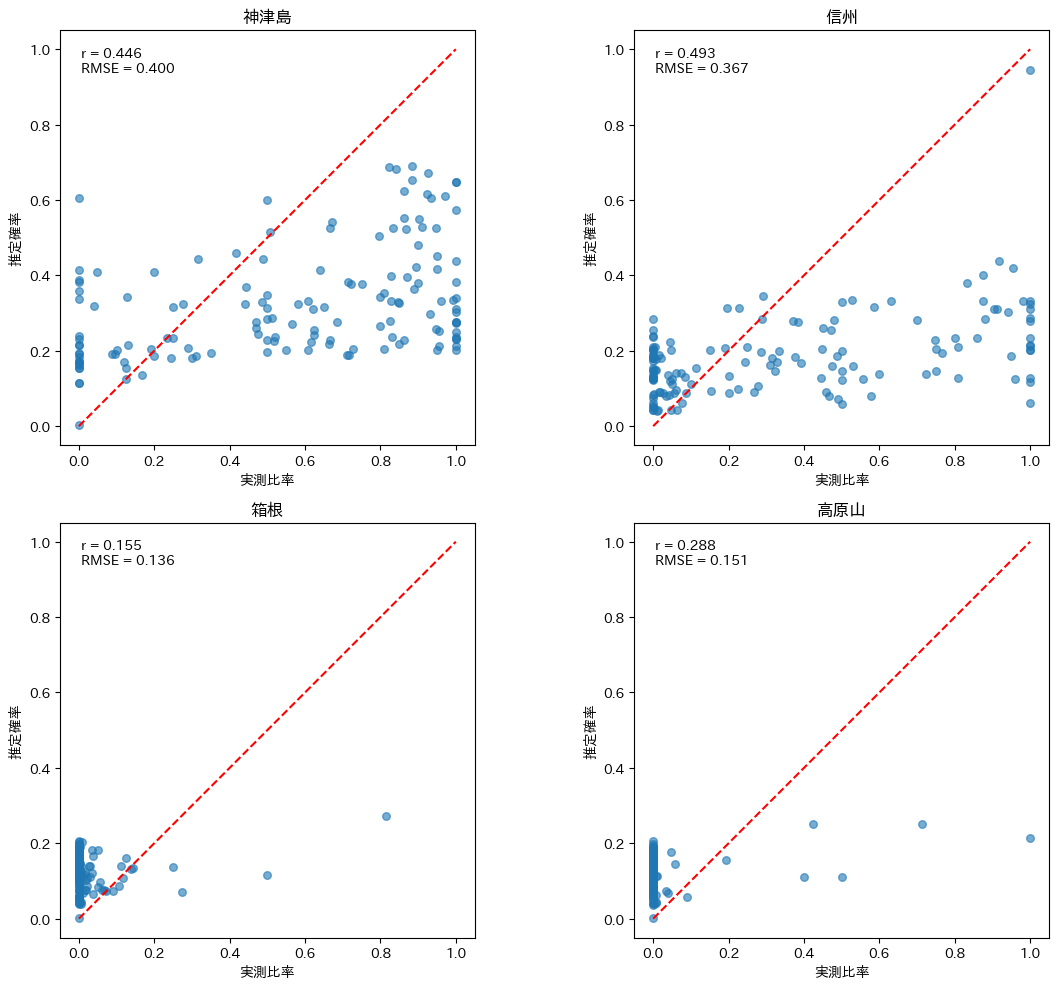

In [18]:
# 真の値と推定値の比較（散布図）
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for k in range(4):
    ax = axes[k]
    ax.scatter(true_ratio[k], site_probs[k], alpha=0.6, s=30)
    ax.plot([0, 1], [0, 1], 'r--', label='y=x')
    ax.set_xlabel('実測比率')
    ax.set_ylabel('推定確率')
    ax.set_title(origins[k])
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_aspect('equal')
    
    # 相関係数
    corr = np.corrcoef(true_ratio[k], site_probs[k])[0, 1]
    rmse = np.sqrt(np.mean((site_probs[k] - true_ratio[k])**2))
    ax.text(0.05, 0.9, f'r = {corr:.3f}\nRMSE = {rmse:.3f}', 
            fontsize=10, transform=ax.transAxes)

plt.tight_layout()
plt.show()

## 10. 数値サマリー

In [19]:
# 推定精度の評価
print("=" * 50)
print("推定精度の評価")
print("=" * 50)
print()

for k, origin in enumerate(origins[:-1]):  # 「その他」を除く
    rmse = np.sqrt(np.mean((site_probs[k] - true_ratio[k])**2))
    mae = np.mean(np.abs(site_probs[k] - true_ratio[k]))
    corr = np.corrcoef(site_probs[k], true_ratio[k])[0, 1]
    
    print(f"{origin}:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  相関: {corr:.4f}")
    print()

推定精度の評価

神津島:
  RMSE: 0.3997
  MAE:  0.3361
  相関: 0.4461

信州:
  RMSE: 0.3672
  MAE:  0.2747
  相関: 0.4927

箱根:
  RMSE: 0.1361
  MAE:  0.1189
  相関: 0.1551

高原山:
  RMSE: 0.1515
  MAE:  0.1290
  相関: 0.2880



In [20]:
# λ*のサマリー
print("=" * 50)
print("λ* の事後サマリー")
print("=" * 50)
print(f"平均:     {results.lambda_star_samples.mean():.2f}")
print(f"中央値:   {np.median(results.lambda_star_samples):.2f}")
print(f"標準偏差: {results.lambda_star_samples.std():.2f}")
print(f"95%CI:    [{np.percentile(results.lambda_star_samples, 2.5):.2f}, "
      f"{np.percentile(results.lambda_star_samples, 97.5):.2f}]")

λ* の事後サマリー
平均:     33.43
中央値:   33.47
標準偏差: 2.56
95%CI:    [28.69, 37.92]


In [21]:
# 偽不在点の統計
print("=" * 50)
print("偽不在点の統計")
print("=" * 50)
n_U_array = np.array(results.n_pseudo_absence)
print(f"平均: {n_U_array.mean():.1f}")
print(f"最小: {n_U_array.min()}")
print(f"最大: {n_U_array.max()}")

偽不在点の統計
平均: 147.2
最小: 101
最大: 189


## 11. 全期間の比較（オプション）

5つの時期で独立にモデルを推定し、比較します。

In [22]:
# 全期間でモデル推定（時間がかかります）
RUN_ALL_PERIODS = True  # Trueに変更すると実行

if RUN_ALL_PERIODS:
    all_results = {}
    all_site_probs = {}
    all_datasets = {}

    for p in range(5):
        print(f"\n{'=' * 60}")
        print(f"Period {p}: {time_periods[p]}")
        print(f"{'=' * 60}")

        # データセット準備
        try:
            dataset_p = prepare_marked_point_process_dataset(
                preprocessor=preprocessor,
                period=p,
                origins=origins,
                grid_subsample_ratio=grid_subsample_ratio,
                drop_zero_total_sites=True,
            )
        except ValueError as e:
            print(f"  スキップ: {e}")
            continue

        if dataset_p.num_sites() == 0:
            print(f"  遺跡なし、スキップ")
            continue

        # MCMC実行
        config_p = MarkedPointProcessConfig(
            n_iter=500,
            burn_in=50,
            thinning=2,
            seed=42,
            neighbor_count=20,
            mark_kernel_lengthscale=0.2,
            mark_kernel_variance=0.1,
        )

        sampler_p = MarkedPointProcessSampler(dataset_p, config_p)
        results_p = sampler_p.run(show_progress=True)

        # 事後確率を計算
        beta_mean_p = results_p.beta_mark_samples.mean(axis=0)
        eta_mean_p = compute_eta(beta_mean_p, dataset_p.design_matrix_marks)
        site_probs_p = softmax_with_baseline(eta_mean_p)

        # 保存
        all_results[p] = results_p
        all_datasets[p] = dataset_p
        all_site_probs[p] = site_probs_p

        print(f"  遺跡数: {dataset_p.num_sites()}")

    print("\n" + "=" * 60)
    print("全期間のモデル推定完了")
    print("=" * 60)
else:
    print("全期間の比較はスキップされました。")
    print("RUN_ALL_PERIODS = True に変更すると実行できます。")


Period 0: 早期・早々期


 60%|██████    | 8177/13575 [00:02<00:01, 3785.18it/s]

MCMC: 100%|██████████| 500/500 [00:19<00:00, 25.15it/s]


  遺跡数: 53

Period 1: 前期


MCMC: 100%|██████████| 500/500 [00:21<00:00, 23.17it/s]


  遺跡数: 61

Period 2: 中期


MCMC: 100%|██████████| 500/500 [00:45<00:00, 11.01it/s]


  遺跡数: 146

Period 3: 後期


MCMC: 100%|██████████| 500/500 [00:21<00:00, 23.20it/s]


  遺跡数: 59

Period 4: 晩期


MCMC: 100%|██████████| 500/500 [00:08<00:00, 56.94it/s]

  遺跡数: 18

全期間のモデル推定完了


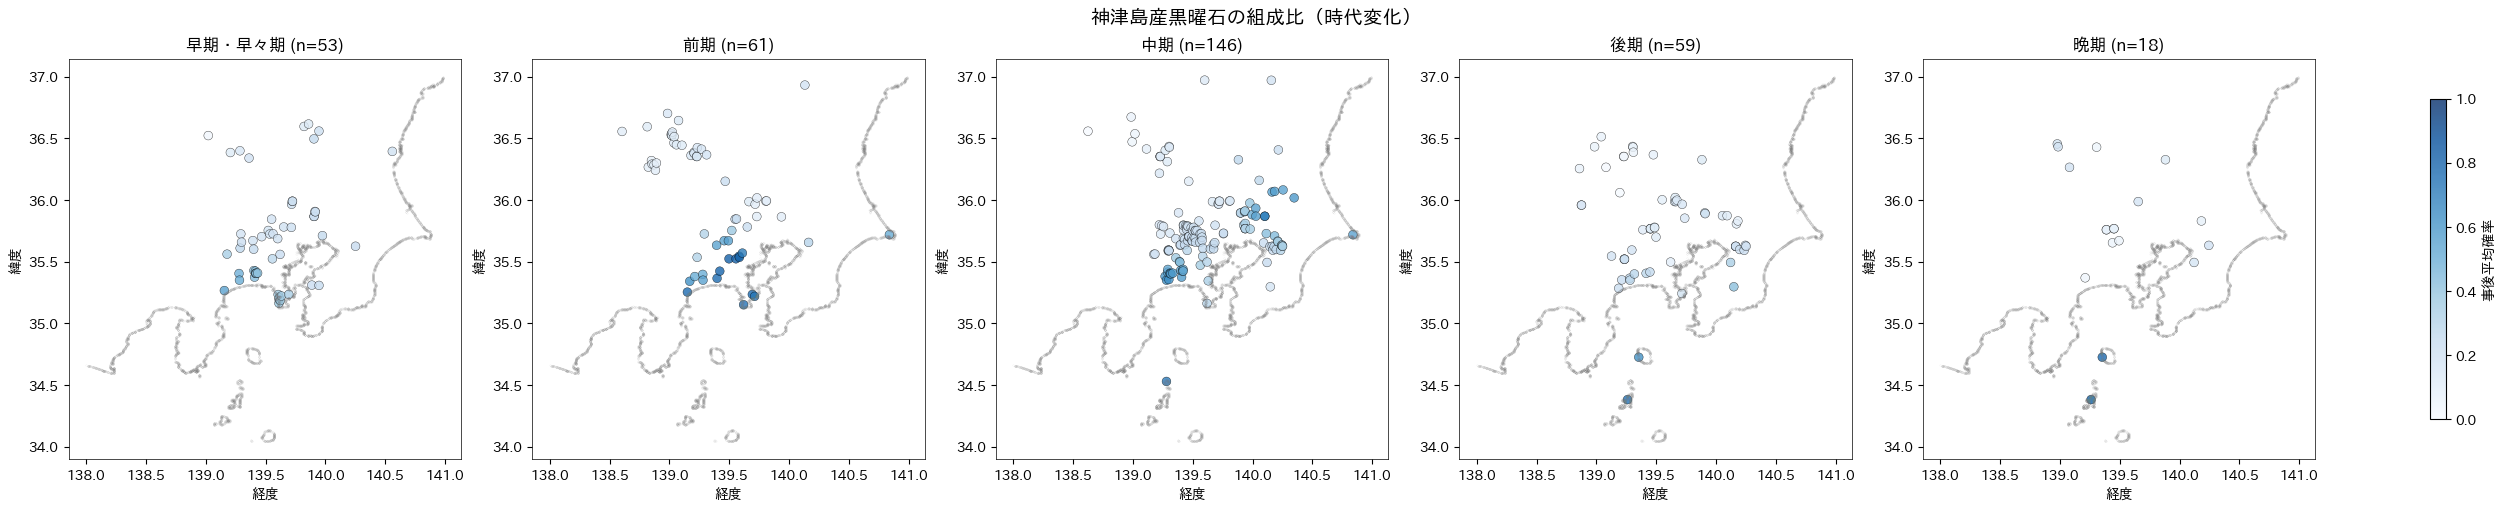

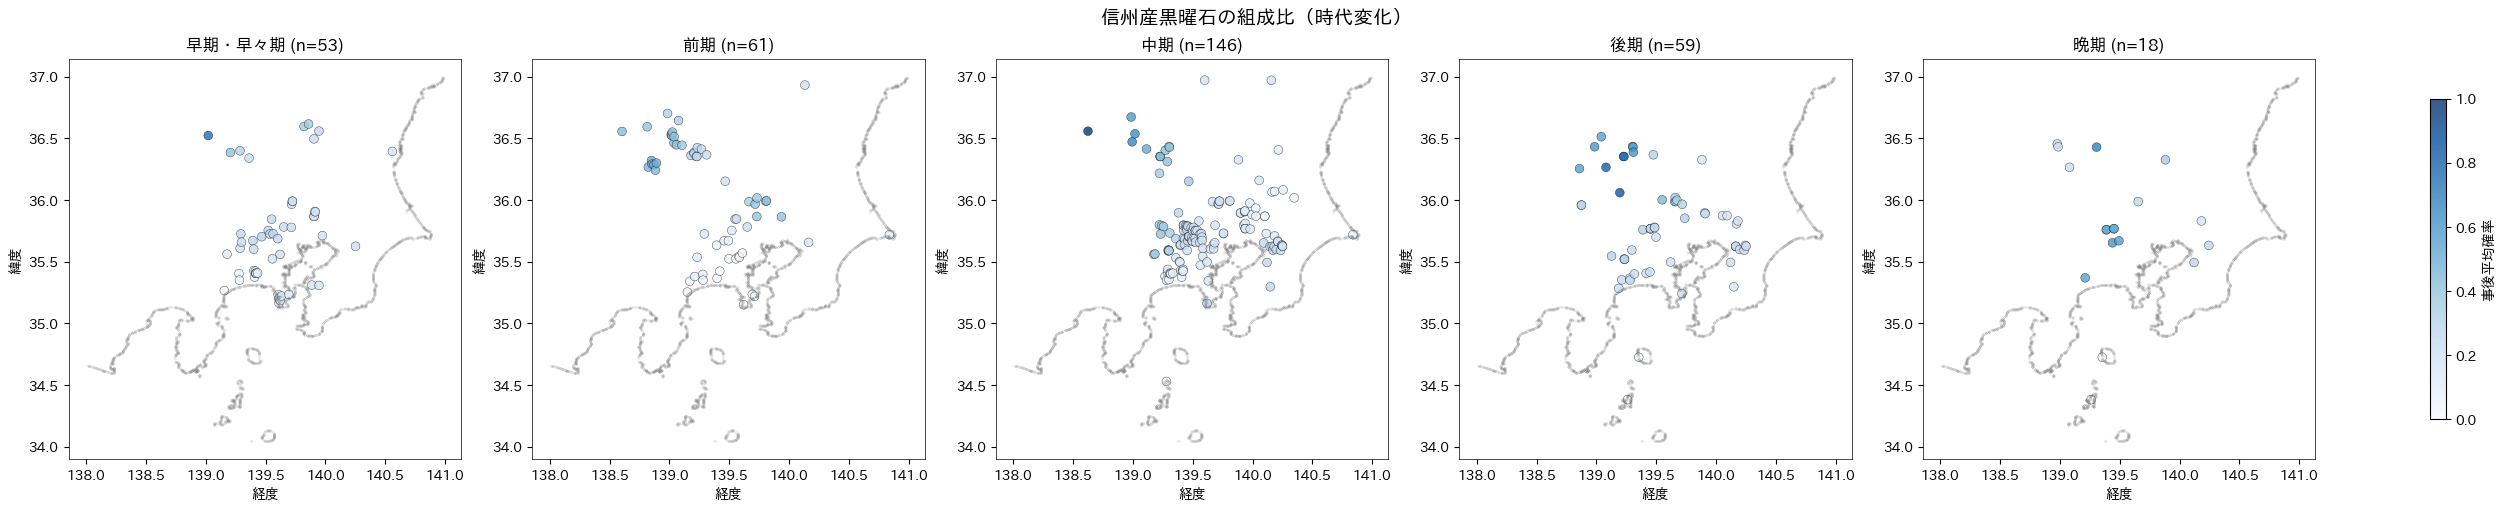

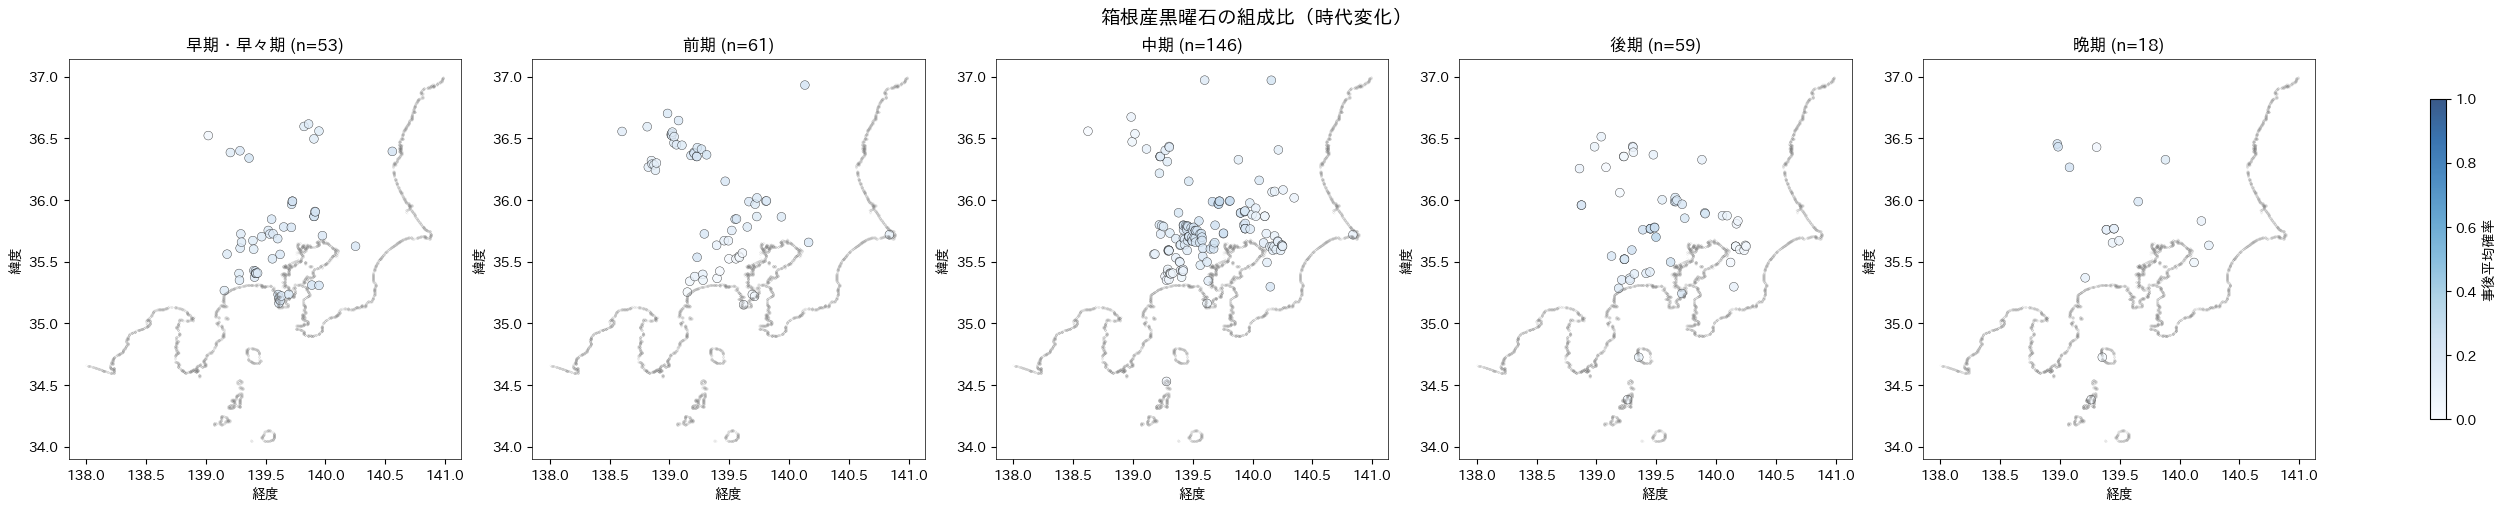

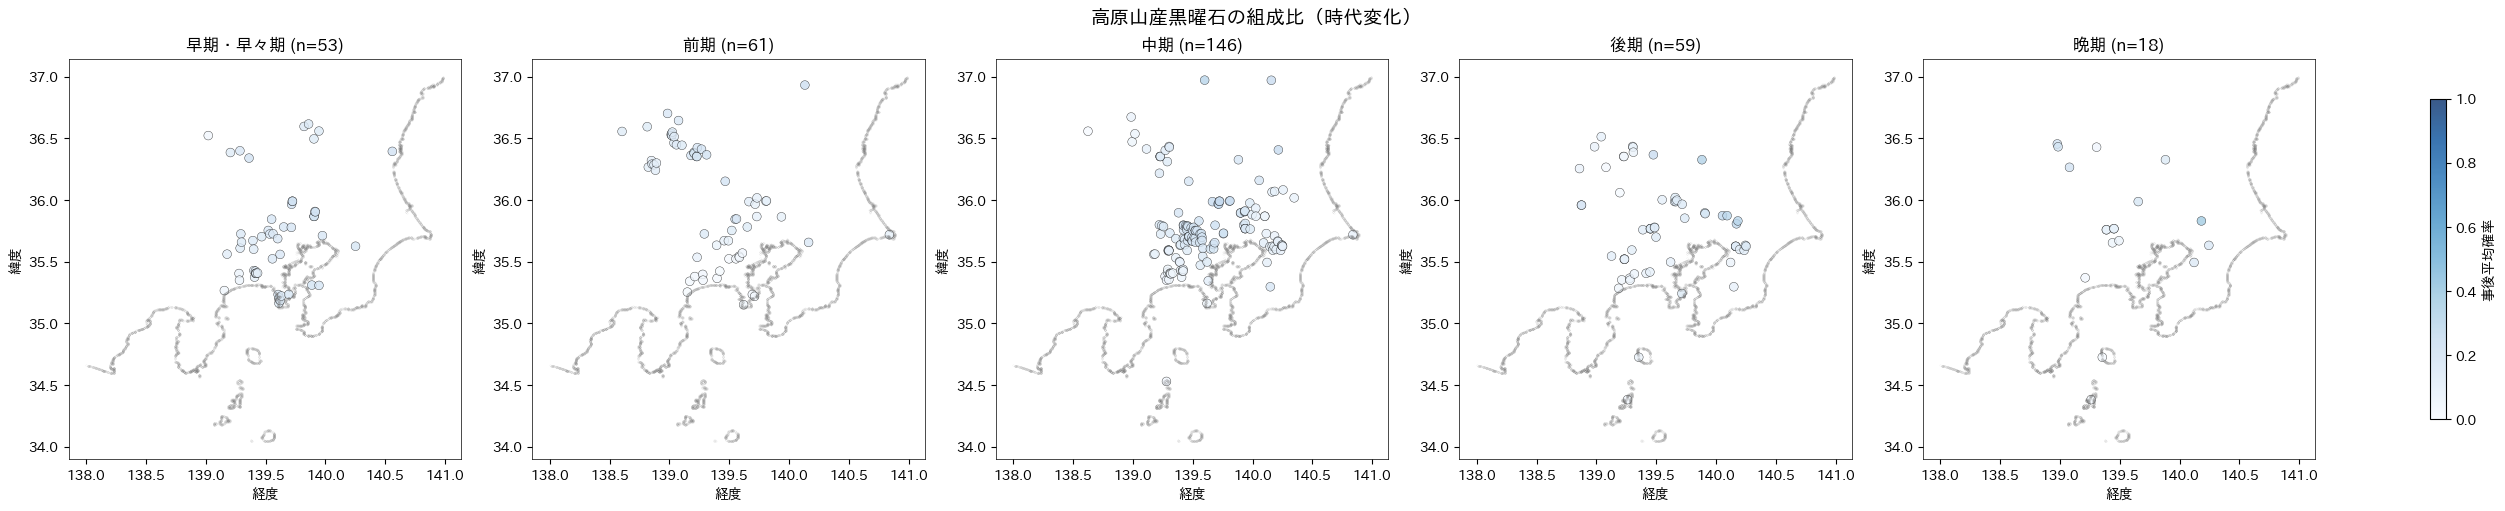

In [23]:
if RUN_ALL_PERIODS and len(all_results) > 0:
    def plot_all_periods_for_origin(origin_index: int):
        """特定の産地について、全期間の事後平均を横並びでプロット"""
        available_periods = sorted(all_results.keys())
        n_periods = len(available_periods)
        
        fig, axes = plt.subplots(1, n_periods, figsize=(5*n_periods, 5), constrained_layout=True)
        if n_periods == 1:
            axes = [axes]

        for ax, p_idx in zip(axes, available_periods):
            dataset_p = all_datasets[p_idx]
            site_probs_p = all_site_probs[p_idx]
            
            # 推定確率
            sc = ax.scatter(
                dataset_p.site_coords[:, 0],
                dataset_p.site_coords[:, 1],
                c=site_probs_p[origin_index],
                cmap="Blues",
                s=40,
                alpha=0.8,
                vmin=0,
                vmax=1,
                edgecolors="black",
                linewidths=0.3,
            )
            
            ax.scatter(boundary[:, 0], boundary[:, 1], c="grey", s=0.001)
            ax.set_title(f"{time_periods[p_idx]} (n={dataset_p.num_sites()})")
            ax.set_xlabel("経度")
            ax.set_ylabel("緯度")

            for spine in ax.spines.values():
                spine.set_linewidth(0.5)

        fig.colorbar(sc, ax=axes, label="事後平均確率", shrink=0.8)
        fig.suptitle(f"{origins[origin_index]}産黒曜石の組成比（時代変化）", fontsize=14)
        plt.show()

    # 4つの主要産地について比較
    for origin_idx in range(4):
        plot_all_periods_for_origin(origin_idx)

## 12. グリッド上での予測

NNGPの条件付き分布を用いて、グリッド上での産地構成比を予測します。

In [24]:
# グリッド上での予測（構成比）
print("グリッド上での予測を計算中...")
grid_probs = results.predict_probabilities(location="grid", sample_conditional=False)
print(f"グリッド予測の形状: {grid_probs.shape}")
print(f"有効グリッド数: {dataset.valid_grids.sum()}")

# 陸地マスクの作成
is_land = dataset.valid_grids

print(f"陸地グリッド数: {is_land.sum()}")

グリッド上での予測を計算中...
グリッド予測の形状: (5, 13575)
有効グリッド数: 7798
陸地グリッド数: 7798


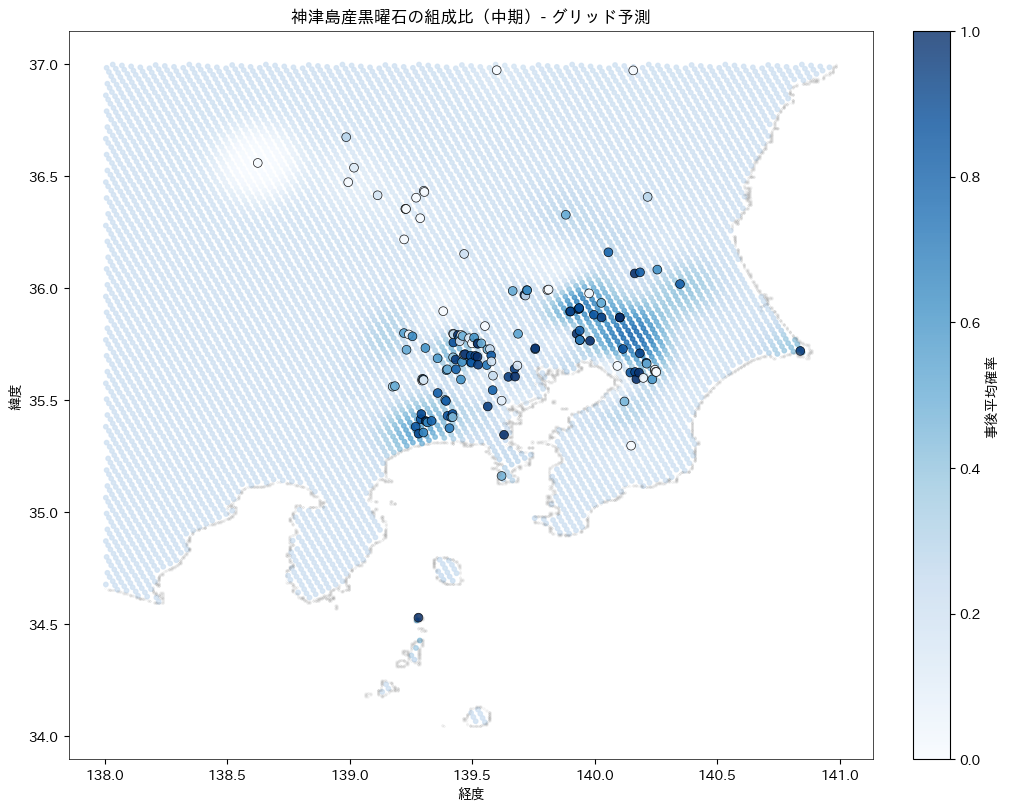

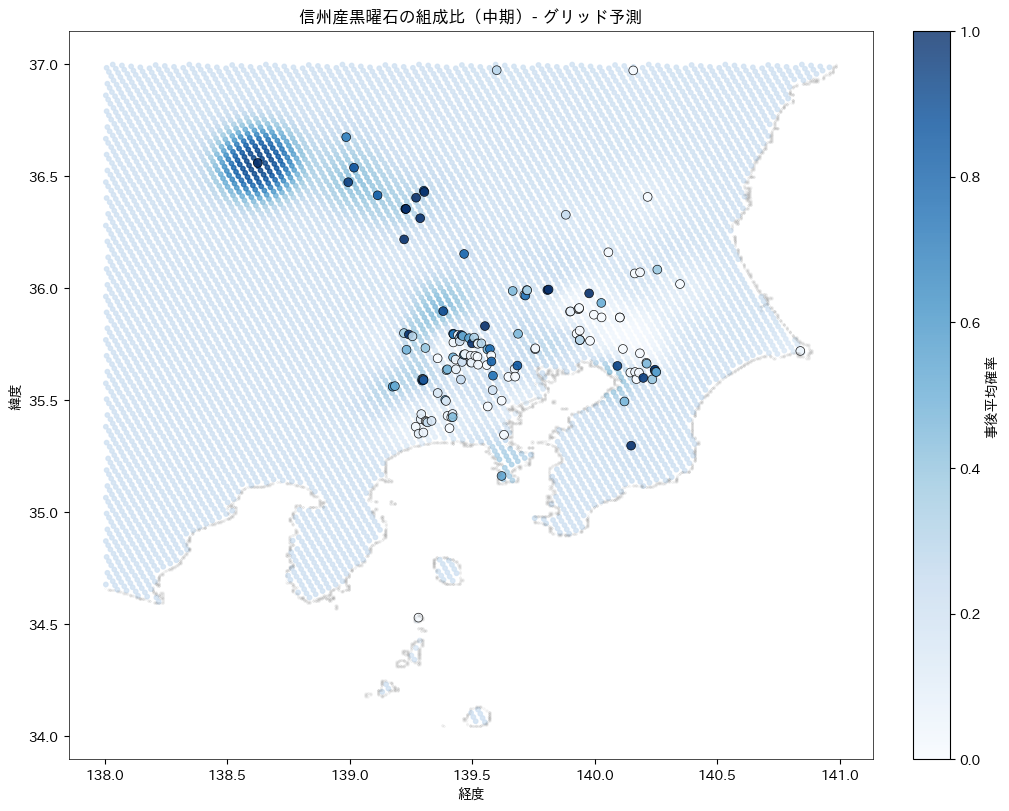

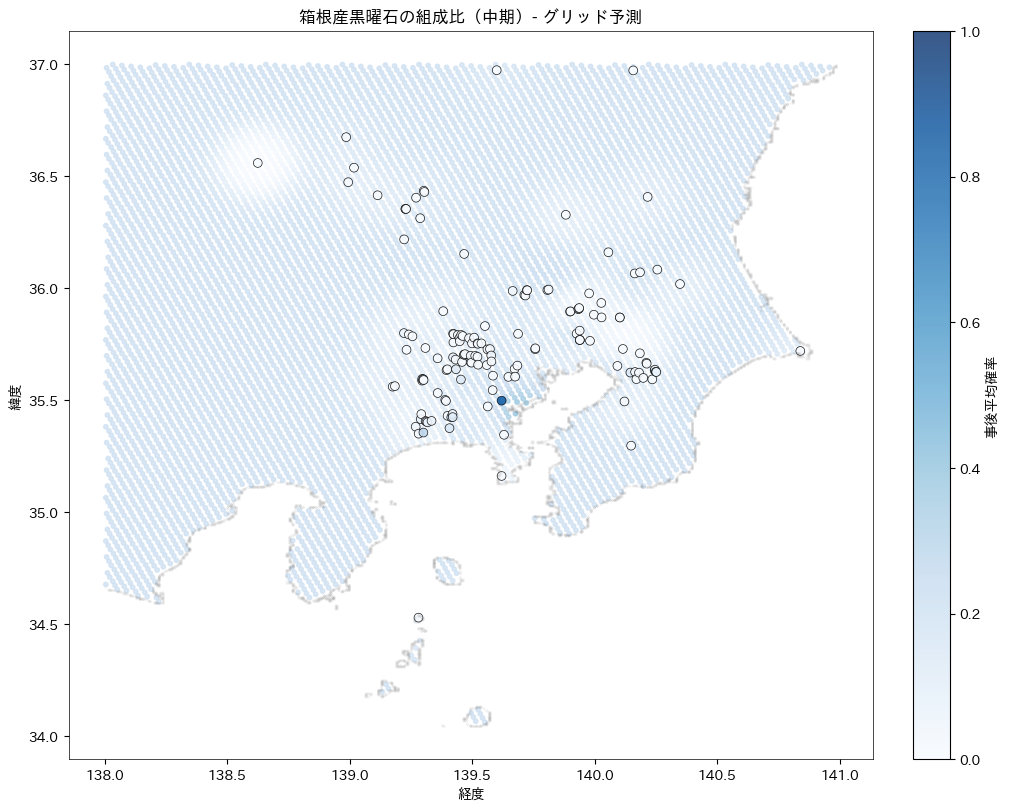

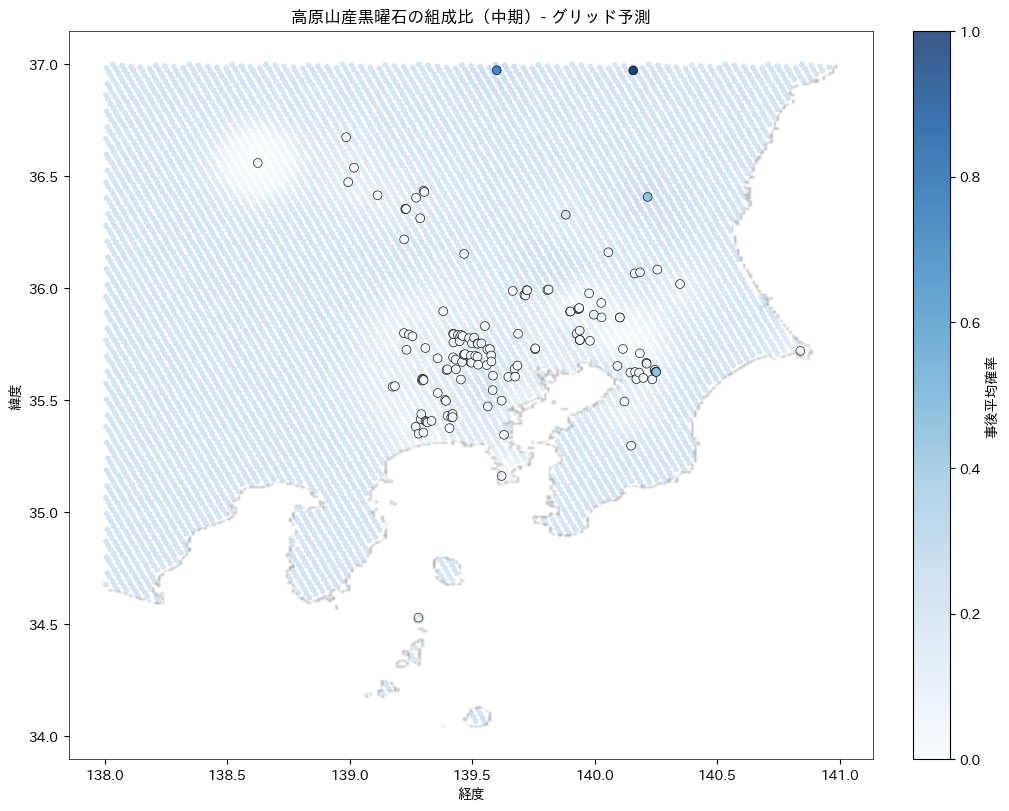

In [25]:
def plot_grid_result(origin_index: int):
    """グリッド上の事後平均をプロット"""
    fig, ax = plt.subplots(1, 1, figsize=(10, 8), constrained_layout=True)

    # グリッド上の事後平均（陸地のみ）
    sc = ax.scatter(
        dataset.grid_coords[is_land, 0],
        dataset.grid_coords[is_land, 1],
        c=grid_probs[origin_index, is_land],
        cmap="Blues",
        s=10,
        alpha=0.8,
        vmin=0,
        vmax=1,
    )

    # 観測地点の実測比率
    ax.scatter(
        dataset.site_coords[:, 0],
        dataset.site_coords[:, 1],
        c=true_ratio[origin_index],
        cmap="Blues",
        s=40,
        edgecolors="black",
        linewidths=0.5,
        alpha=0.9,
        vmin=0,
        vmax=1,
    )
    
    # 境界
    ax.scatter(boundary[:, 0], boundary[:, 1], c="grey", s=0.001)

    plt.colorbar(sc, ax=ax, label="事後平均確率")
    ax.set_title(f"{origins[origin_index]}産黒曜石の組成比（{time_periods[period]}）- グリッド予測")
    ax.set_xlabel("経度")
    ax.set_ylabel("緯度")

    for spine in ax.spines.values():
        spine.set_linewidth(0.5)

    plt.show()


# 4つの産地について可視化
for k in range(4):
    plot_grid_result(k)

## 13. 遺跡存在強度のプロット

点過程モデルの強度関数 $\lambda(s) = \lambda^* \cdot q(s)$ をグリッド上でプロットします。
現在の実装では簡略化のため $q(s) = 0.5$（$\eta = 0$）としています。

強度の範囲: [6.7063, 21.7048]
平均強度: 16.5783


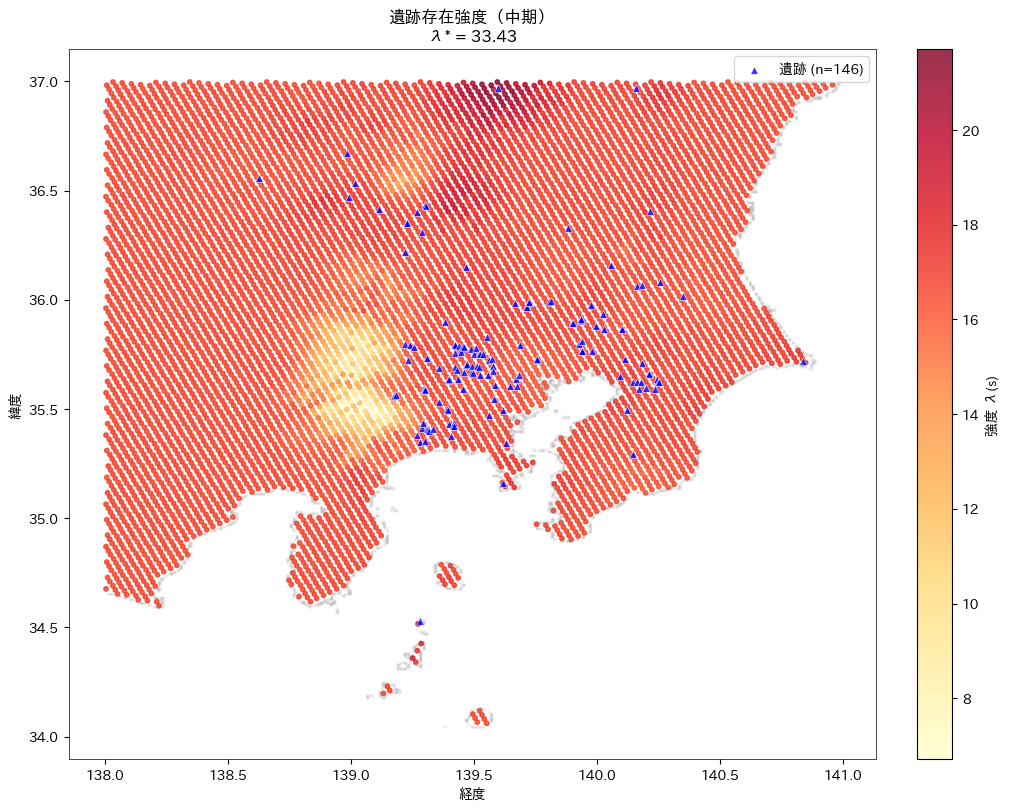

In [26]:
# グリッド上での強度予測
grid_intensity = results.predict_intensity(location="grid")

# 陸地のみでの統計（NaNを含む無効なグリッドを除外）
intensity_land = grid_intensity[is_land]
print(f"強度の範囲: [{intensity_land.min():.4f}, {intensity_land.max():.4f}]")
print(f"平均強度: {intensity_land.mean():.4f}")

# 強度のプロット
fig, ax = plt.subplots(1, 1, figsize=(10, 8), constrained_layout=True)

# グリッド上の強度（陸地のみ）
sc = ax.scatter(
    dataset.grid_coords[is_land, 0],
    dataset.grid_coords[is_land, 1],
    c=grid_intensity[is_land],
    cmap="YlOrRd",
    s=10,
    alpha=0.8,
)

# 観測地点（遺跡）
ax.scatter(
    dataset.site_coords[:, 0],
    dataset.site_coords[:, 1],
    c="blue",
    s=30,
    marker="^",
    edgecolors="white",
    linewidths=0.5,
    alpha=0.8,
    label=f"遺跡 (n={dataset.num_sites()})",
)

# 境界
ax.scatter(boundary[:, 0], boundary[:, 1], c="grey", s=0.001)

plt.colorbar(sc, ax=ax, label="強度 λ(s)")
ax.set_title(f"遺跡存在強度（{time_periods[period]}）\nλ* = {results.lambda_star_samples.mean():.2f}")
ax.set_xlabel("経度")
ax.set_ylabel("緯度")
ax.legend(loc="upper right")

for spine in ax.spines.values():
    spine.set_linewidth(0.5)

plt.show()

## 14. 全産地のグリッド予測一覧

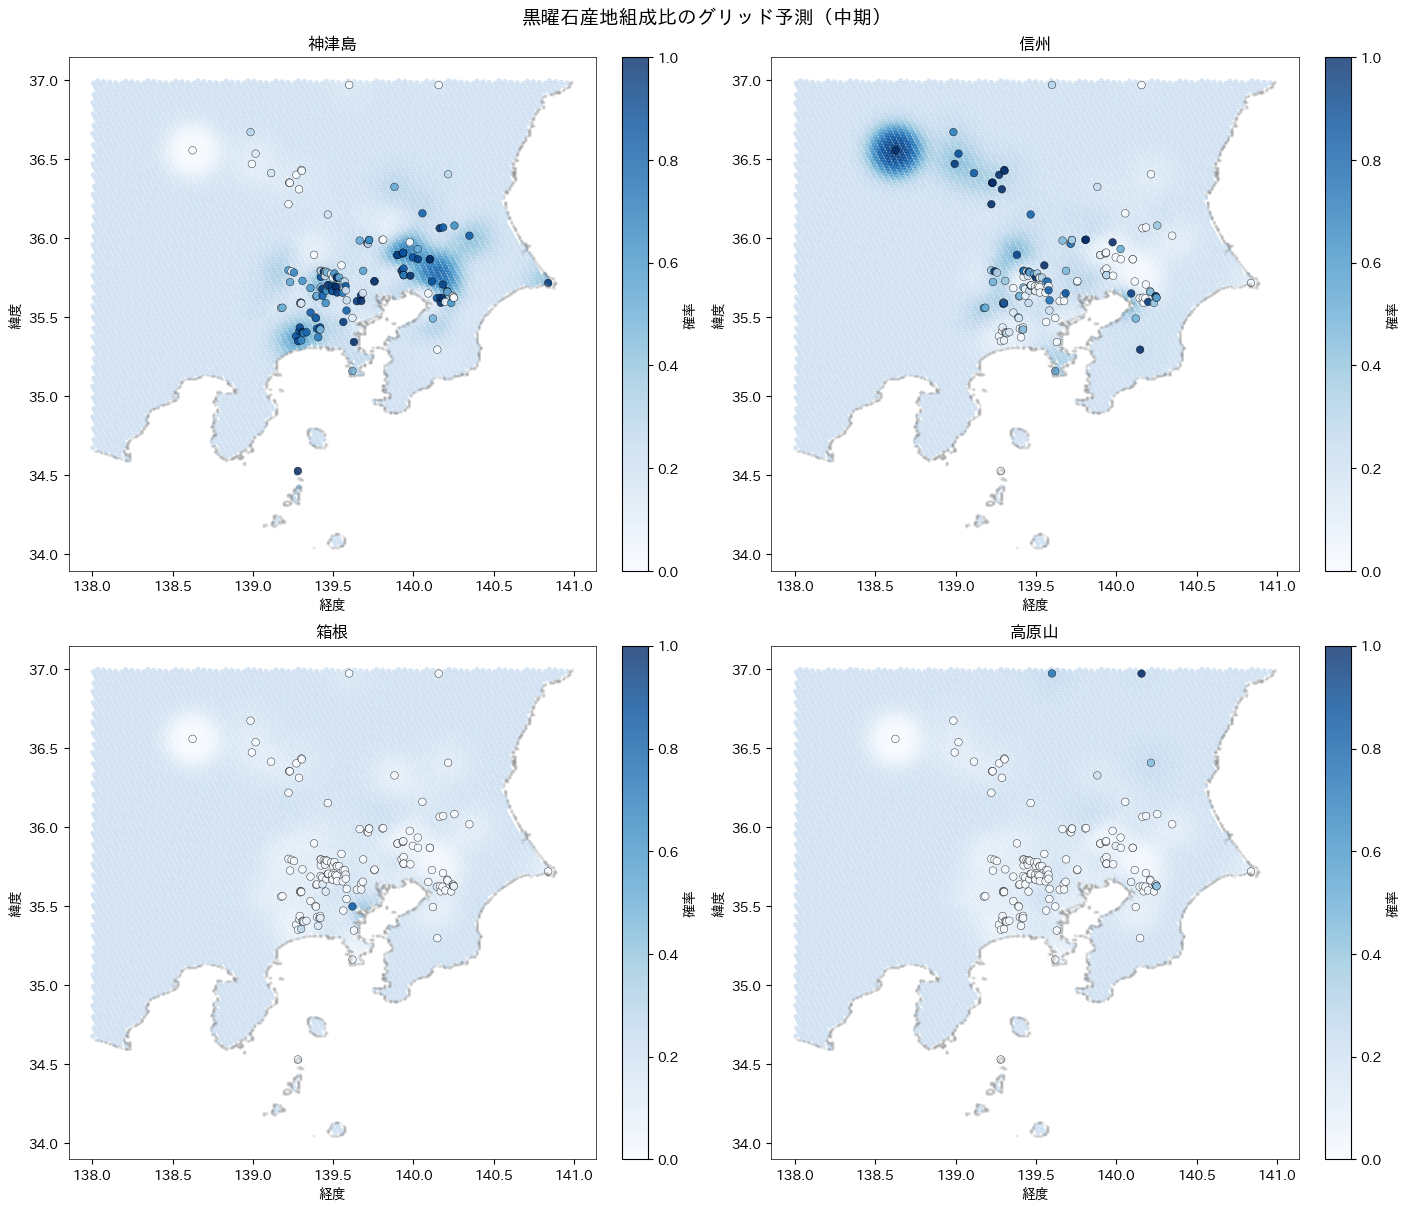

In [27]:
def plot_all_origins_grid():
    """全産地（4つ）を2×2でグリッド予測プロット"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 12), constrained_layout=True)
    axes = axes.flatten()

    for idx in range(4):  # 4つの主要産地
        ax = axes[idx]
        
        # グリッド上の事後平均
        sc = ax.scatter(
            dataset.grid_coords[is_land, 0],
            dataset.grid_coords[is_land, 1],
            c=grid_probs[idx, is_land],
            cmap="Blues",
            s=8,
            alpha=0.8,
            vmin=0,
            vmax=1,
        )
        
        # 観測地点の実測比率
        ax.scatter(
            dataset.site_coords[:, 0],
            dataset.site_coords[:, 1],
            c=true_ratio[idx],
            cmap="Blues",
            s=30,
            edgecolors="black",
            linewidths=0.3,
            alpha=0.9,
            vmin=0,
            vmax=1,
        )
        
        # 境界
        ax.scatter(boundary[:, 0], boundary[:, 1], c="grey", s=0.001)

        plt.colorbar(sc, ax=ax, label="確率")
        ax.set_title(f"{origins[idx]}")
        ax.set_xlabel("経度")
        ax.set_ylabel("緯度")

        for spine in ax.spines.values():
            spine.set_linewidth(0.5)

    fig.suptitle(f"黒曜石産地組成比のグリッド予測（{time_periods[period]}）", fontsize=14)
    plt.show()

plot_all_origins_grid()

## まとめ

このノートブックでは、マーク付き点過程モデルを実データ（黒曜石）に適用しました。

### 実装した機能
1. **点過程部分**: 遺跡の存在確率 $q(s) = \text{sigmoid}(\eta_{\text{int}})$
2. **マーク部分**: 産地構成比 $\pi_k(s) = \text{softmax}(\eta_k)$
3. **空間効果**: NNGP（Nearest Neighbor Gaussian Process）による空間相関
4. **グリッド予測**: 条件付きNNGPによる未観測地点への外挿

### 確認したこと
1. `prepare_marked_point_process_dataset`を使用した実データの読み込み
2. MCMCサンプラーの実行と収束確認（トレースプロット）
3. 産地別の事後平均確率の可視化（遺跡およびグリッド）
4. 実測値との比較（散布図、相関係数、RMSE）
5. 遺跡存在強度のマップ表示

### 今後の拡張
- 距離事前分布の追加（notebook 28と同様）
- 点過程側のNNGP空間効果の完全実装（現在は$\eta_{\text{int}}=0$で簡略化）
- 時空間モデル（AR(1)時間構造）の導入
- 効果の分解（距離事前 vs データ駆動）